## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

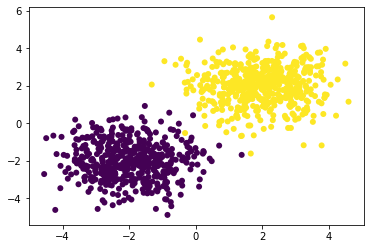

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [5]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [6]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [7]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

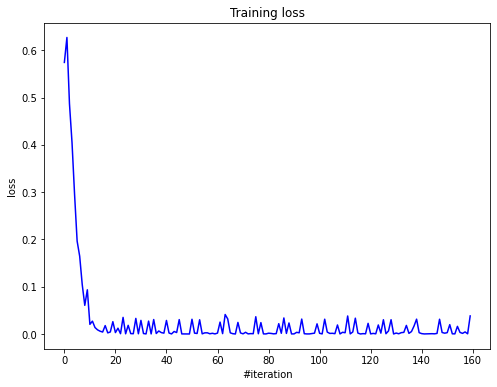

Current loss: 0.038156


In [8]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [9]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

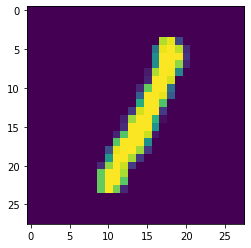

In [12]:
plt.imshow(X_train[345].reshape(28, 28))

One-hot encode the labels first.

In [9]:
def make_hot_encode(y, num):
    result = np.zeros(shape = (y.shape[0],num))
    result[np.arange(y.shape[0]), y] = 1
    return result

In [10]:
y_train = make_hot_encode(y_train, 10)
y_val = make_hot_encode(y_val, 10)
y_test = make_hot_encode(y_test, 10)

In [11]:
X_train = X_train.reshape((X_train.shape[0], np.prod(X_train.shape[1:])))
X_val = X_val.reshape((X_val.shape[0], np.prod(X_val.shape[1:])))
X_test = X_test.reshape((X_test.shape[0], np.prod(X_test.shape[1:])))

In [12]:
def make_train(n_epoch, X, Y, batch_size, net, criterion, optimizer_config, optimizer, X_val, y_val):
    loss_history = []
    loss_val_history = []
    optimizer_state = {}

    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X, Y), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            optimizer(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      

            loss_history.append(loss)
        net.evaluate()
        preds = net.forward(X_val)
        loss_val_history.append(criterion.forward(preds, y_val))
        net.train()
    return loss_history, loss_val_history

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [13]:
def create_net(activation_func):
    net = Sequential()
    net.add(Linear(28 * 28, 400))
    net.add(activation_func())
    net.add(Linear(400, 10))
    net.add(LogSoftMax())
    return net

In [14]:
def make_plot(history, labels, val_losses):
    display.clear_output(wait=True)
    plt.figure(figsize=(10, 10))
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.yscale("log")
    for his, label in zip(history, labels):
        plt.plot(his, label = label)
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 10))
    plt.title("Validation loss")
    plt.xlabel("#epoch")
    plt.ylabel("loss")
    plt.yscale("log")
    for his, label in zip(val_losses, labels):
        plt.plot(his, label = label)
    plt.legend()
    plt.show()
    for loss, label in zip(np.array(val_losses)[:, -1], labels):
        print(f'For {label} loss is {loss}')

In [15]:
activation_funcs = (ReLU, ELU, LeakyReLU, SoftPlus)
history = []
losses = []
n_epoch = 10
batch_size = 512
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
criterion = ClassNLLCriterion()

labels = "ReLU, ELU, LeakyReLU, SoftPlus".split(", ")
for activation_func in activation_funcs:
    net = create_net(activation_func)
    loss = make_train(n_epoch, X_train, y_train, batch_size, net, criterion, 
                      optimizer_config, sgd_momentum, X_val, y_val)
    history.append(loss[0])
    losses.append(loss[1])

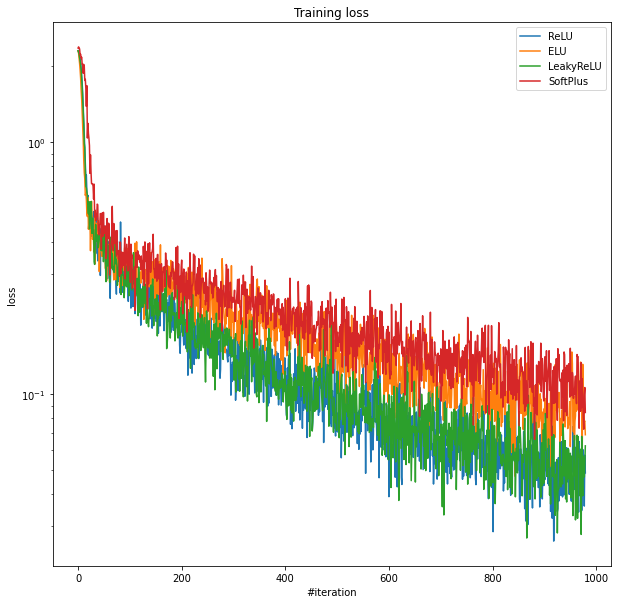

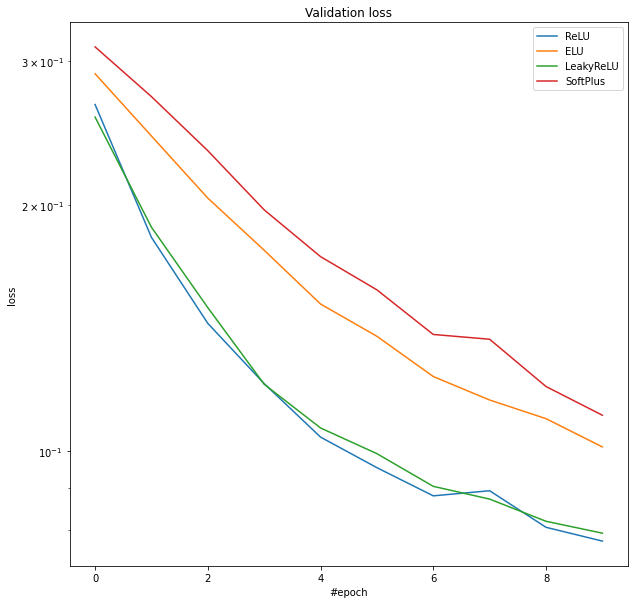

For ReLU loss is 0.07753999695011288
For ELU loss is 0.10109832080551732
For LeakyReLU loss is 0.07928906757767462
For SoftPlus loss is 0.11054619051349257


In [16]:
make_plot(np.array(history), labels, np.array(losses))

__Conclusion:__ ReLU and LeakyReLU are best activation functions for our set.

In [17]:
def create_net_with_normalization(activation_func, alpha):
    net = Sequential()
    net.add(Linear(28 * 28, 400))
    net.add(BatchNormalization(alpha))
    net.add(ChannelwiseScaling(400))
    net.add(activation_func())
    net.add(BatchNormalization(alpha))
    net.add(ChannelwiseScaling(400))
    net.add(Linear(400, 10))
    net.add(LogSoftMax())
    return net

In [18]:
n_epoch = 10
batch_size = 512
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
criterion = ClassNLLCriterion()

history = []
losses = []
alphas = [0, 0.2, 0.4, 0.6, 0.8]
labels = [f"ReLU with normalization {alpha}" for alpha in alphas] + ["ReLU without normalization"]
for alpha in alphas:
    net_norm = create_net_with_normalization(ReLU, alpha)
    loss = make_train(n_epoch, X_train, y_train, batch_size, net_norm, criterion, 
                      optimizer_config, sgd_momentum, X_val, y_val)
    history.append(loss[0])
    losses.append(loss[1])

net = create_net(ReLU)
loss = make_train(n_epoch, X_train, y_train, batch_size, net, criterion, 
                      optimizer_config, sgd_momentum, X_val, y_val)
history.append(loss[0])
losses.append(loss[1])  

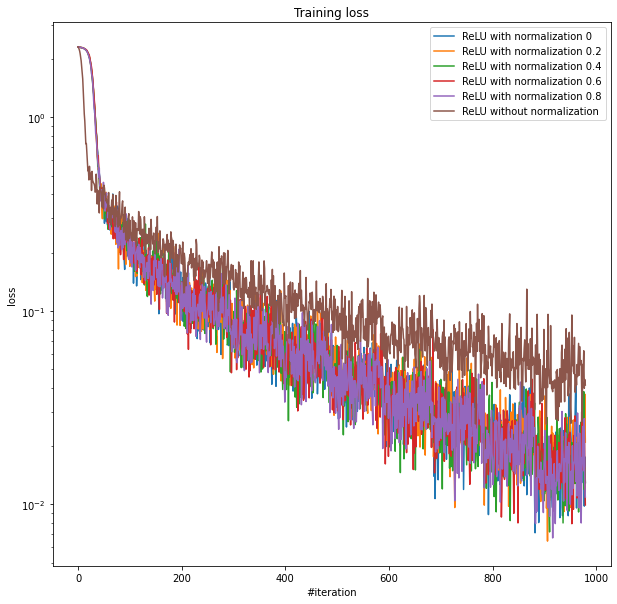

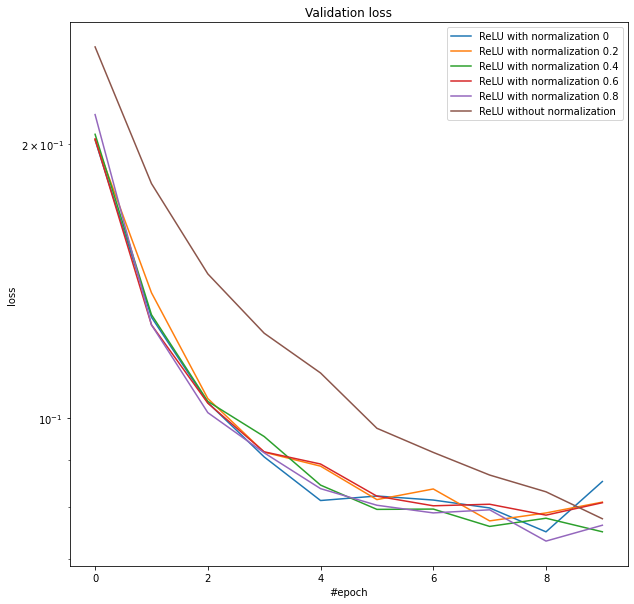

For ReLU with normalization 0 loss is 0.08522480653049715
For ReLU with normalization 0.2 loss is 0.08089787799312635
For ReLU with normalization 0.4 loss is 0.07505742455314146
For ReLU with normalization 0.6 loss is 0.08078034164405108
For ReLU with normalization 0.8 loss is 0.07631203708905186
For ReLU without normalization loss is 0.07757136836153955


In [19]:
make_plot(history, labels, losses)

__Conclusion:__ How do we see, BatchNormalization helps us a little!

In [20]:
learning_rates = [1, 1e-1, 1e-2, 1e-3, 1e-4]

n_epoch = 10
batch_size = 512
criterion = ClassNLLCriterion()
history = []
losses = []
labels = [f"SGD with learning_rate {rate}" for rate in learning_rates]

for learning_rate in learning_rates:
    net_us = create_net(ReLU)
    optimizer_config = {'learning_rate' : learning_rate, 'momentum': 0.9}
    loss = make_train(n_epoch, X_train, y_train, batch_size, net_us, criterion, 
                       optimizer_config, sgd_momentum, X_val, y_val)
    history.append(loss[0])
    losses.append(loss[1])

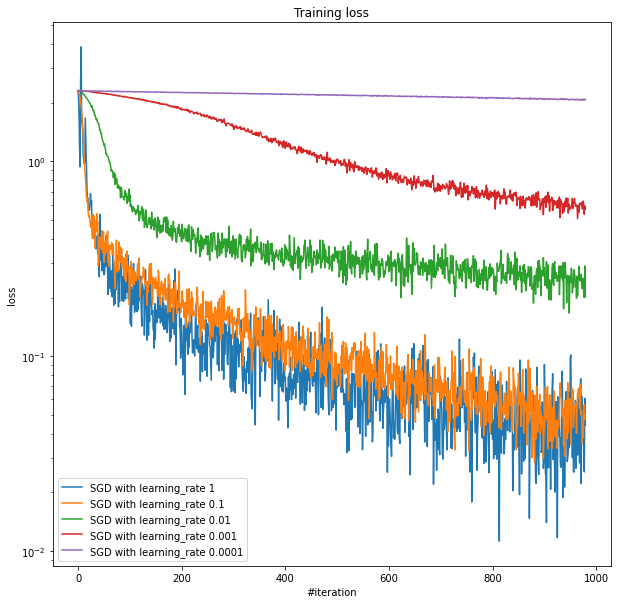

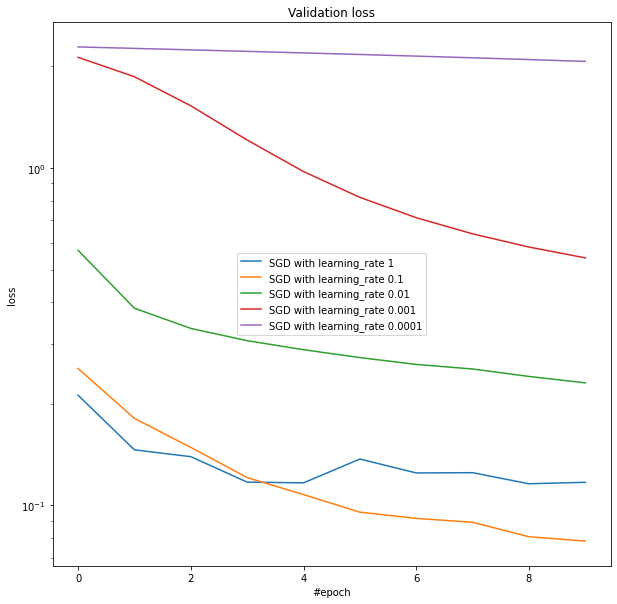

For SGD with learning_rate 1 loss is 0.11712435283492234
For SGD with learning_rate 0.1 loss is 0.07843313196767229
For SGD with learning_rate 0.01 loss is 0.23077685644815243
For SGD with learning_rate 0.001 loss is 0.5413274972751564
For SGD with learning_rate 0.0001 loss is 2.0676082739882897


In [21]:
make_plot(history, labels, losses)

__Conclusion:__ How do we see, learning rate 0.1 is best for SGD.

In [22]:
betas = [[0.1, 0.9], [0.3, 0.7], [0.3, 0.9], [0.5, 0.7], [0.7, 0.7], [0.9, 0.999], [0.7, 0.999]]
n_epoch = 10
batch_size = 512
criterion = ClassNLLCriterion()
history = []
losses = []
labels = [f"Adam with beta1={rate[0]}, beta2={rate[1]}" for rate in betas]

for beta in betas:
    net_us = create_net(ReLU)
    optimizer_config = {'learning_rate' : 1e-3, 'beta1': beta[0], 'beta2':beta[1], 'epsilon':1e-8}
    loss = make_train(n_epoch, X_train, y_train, batch_size, net_us, criterion, 
                       optimizer_config, adam_optimizer, X_val, y_val)
    history.append(loss[0])
    losses.append(loss[1])

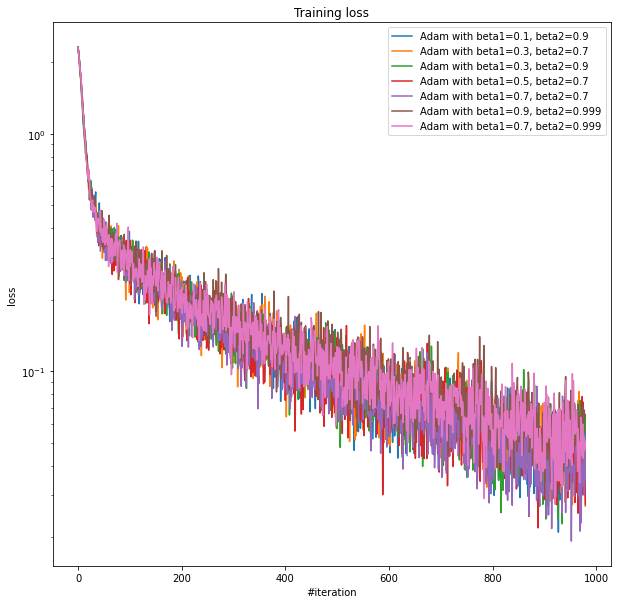

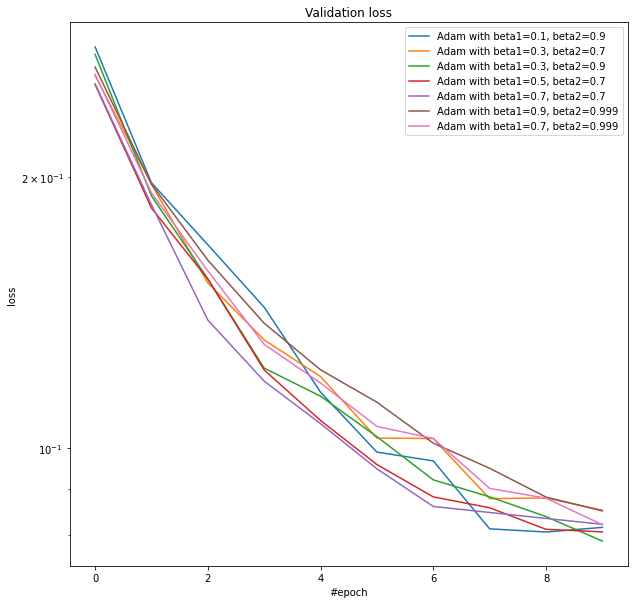

For Adam with beta1=0.1, beta2=0.9 loss is 0.08167596300166066
For Adam with beta1=0.3, beta2=0.7 loss is 0.08533551901453353
For Adam with beta1=0.3, beta2=0.9 loss is 0.07886481284258214
For Adam with beta1=0.5, beta2=0.7 loss is 0.0807420665576852
For Adam with beta1=0.7, beta2=0.7 loss is 0.08232442910443753
For Adam with beta1=0.9, beta2=0.999 loss is 0.08518417028001492
For Adam with beta1=0.7, beta2=0.999 loss is 0.08223455760887266


In [23]:
make_plot(history, labels, losses)

__Conclusion:__ How do we see, Adam is better that SGB and all parameters are good.

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [24]:
def create_net_with_dropout(activation_func, alpha):
    net = Sequential()
    net.add(Linear(28 * 28, 400))
    net.add(Dropout(alpha))
    net.add(activation_func())
    net.add(Dropout(alpha))
    net.add(Linear(400, 10))
    net.add(LogSoftMax())
    return net

In [25]:
n_epoch = 10
batch_size = 512
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
criterion = ClassNLLCriterion()

history = []
losses = []
alphas = [0.1, 0.3, 0.5, 0.7, 0.9]
labels = [f"ReLU with dropout {alpha}" for alpha in alphas] + ["ReLU without dropout"]
for alpha in alphas:
    net_norm = create_net_with_dropout(ReLU, alpha)
    loss = make_train(n_epoch, X_train, y_train, batch_size, net_norm, criterion, 
                      optimizer_config, sgd_momentum, X_val, y_val)
    history.append(loss[0])
    losses.append(loss[1])

net = create_net(ReLU)
loss = make_train(n_epoch, X_train, y_train, batch_size, net, criterion, 
                      optimizer_config, sgd_momentum, X_val, y_val)
history.append(loss[0])
losses.append(loss[1])  

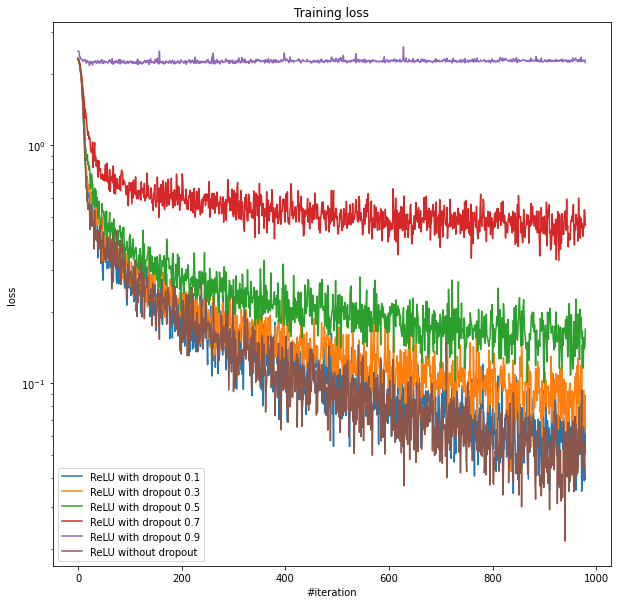

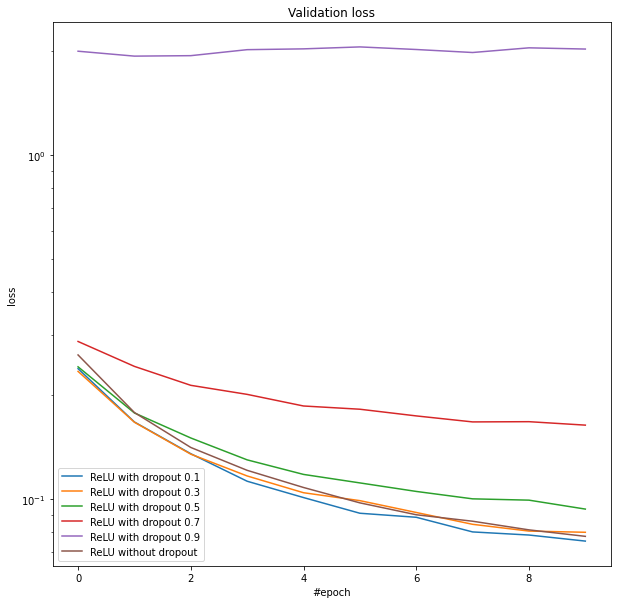

For ReLU with dropout 0.1 loss is 0.07549876885958863
For ReLU with dropout 0.3 loss is 0.08008494406878636
For ReLU with dropout 0.5 loss is 0.0935283786806792
For ReLU with dropout 0.7 loss is 0.1640095324558968
For ReLU with dropout 0.9 loss is 2.0305382073461646
For ReLU without dropout loss is 0.0779345351446196


In [26]:
make_plot(history, labels, losses)

__Conclusion:__ Dropout also gives us little improvement!

In [27]:
def create_best():
    result = Sequential()
    result.add(Linear(28 * 28, 200))
    result.add(Dropout(0.5))
    result.add(ReLU())
    result.add(BatchNormalization(0.4))
    result.add(ChannelwiseScaling(200))
    result.add(Linear(200, 10))
    result.add(LogSoftMax())
    result.add(Dropout(0.5))
    return result

In [28]:
n_epoch = 10
batch_size = 512
optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9, 'beta1': 0.3, 'beta2':0.7, 'epsilon':1e-8}
criterion = ClassNLLCriterion()

best_net = create_best()
history, val_history = make_train(n_epoch, X_train, y_train, batch_size, best_net, criterion, 
                      optimizer_config, adam_optimizer, X_val, y_val)

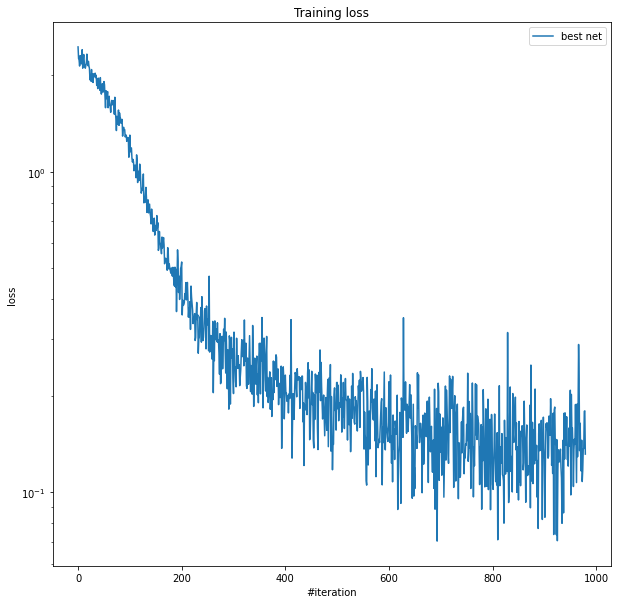

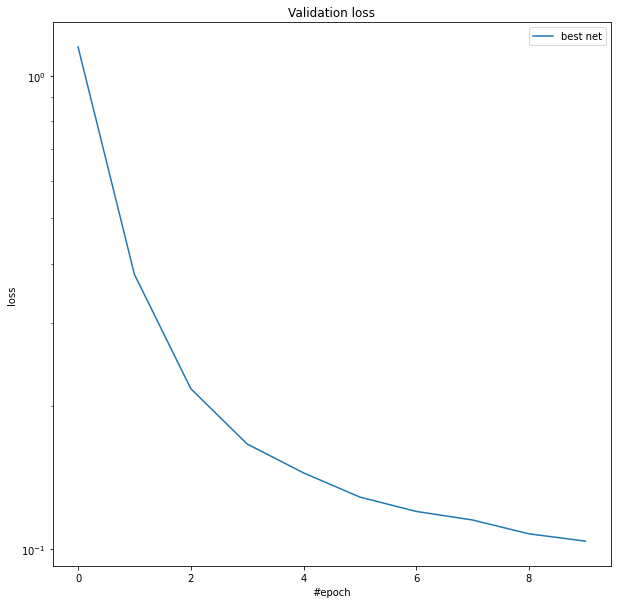

For best net loss is 0.10374759498435321


In [29]:
make_plot([history], ["best net"], [val_history])


Print here your accuracy on test set. It should be around 90%.

In [35]:
from sklearn.metrics import accuracy_score
best_net.evaluate()
preds = make_hot_encode(np.argmax(best_net.forward(X_test), axis = 1), 10)
print(accuracy_score(preds, y_test))

0.9619


__Conclusion:__ That's awesome.

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [31]:
import torch

best = torch.nn.Sequential(
    torch.nn.Flatten(),  
    torch.nn.Linear(28 * 28, 200),
    torch.nn.Dropout(0.5),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(200, 0.4),
    torch.nn.Linear(200, 10),
    torch.nn.Dropout(0.5),
    torch.nn.LogSoftmax(dim=1)
)
optimizer = torch.optim.Adam(best.parameters(), lr = 1e-3)

In [32]:
def make_train_torch(n_epoch, X, Y, batch_size, net, criterion, optimizer):
    loss_history = []
    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X, Y), batch_size):

           # net.zeroGradParameters()

            # Forward
            predictions = net.forward(torch.tensor(x_batch))
            loss = criterion(predictions, torch.tensor(np.argmax(y_batch, axis = 1)))

            # Backward
            #dp = criterion.backward(predictions, torch.tensor(y_batch))
            loss.backward()

            # Update weights
            optimizer.step() 
            optimizer.zero_grad()

            loss_history.append(loss)
    return loss_history


In [33]:
best.train(mode =  False)
n_epoch = 10
batch_size = 512
loss = make_train_torch(n_epoch, X_train, y_train, batch_size, best, torch.nn.functional.nll_loss, optimizer)

In [34]:
from sklearn.metrics import accuracy_score
preds = make_hot_encode(np.argmax(best.forward(torch.tensor(X_test)).data.numpy(), axis = 1), 10)
print(accuracy_score(preds, y_test))

0.97


__Conclusion:__ Nice rate!